<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<h1 align="center"> Analysis of U.S. Wildfire Cause from 1990 - 2015 </h1>  

<h4 align="center">Andrew Nolan</h4>

**Table of Contents:**
- [Project Overview](#intro)
- [Exploratory Data Analysis](#EDA)  
  - [Reading / Data Cleaning](#cleaning)
  - [Visualization](#visualization)
- [Modelling](#modeling)  
  - [Simple Tree](#tree)
  - [Bagging](#bagging)
  - [Random Forest](#forest)
  - [Boosting](#boosting)
  - [Extereme Gradient Boosting](#xgboost)
  - [Support Vector Machines](#SVM)
- [Disscusion / Conclusions](#second-bullet)  



[add a toc](https://stackoverflow.com/questions/21151450/how-can-i-add-a-table-of-contents-to-an-ipython-notebook)   

## Project Overview <a class="anchor" id="intro"></a>

<p style="margin-top:5mm; text-align:center"> We have done our inital exploratory data analysis in the <code>FIRE_EDA</code> notebook. Here we are going to use the information that we gleamed from that to do some modeling. First thing first we are going to try and predict the cause of a wildfire based on the size, burn time, location, and the time that it occured.</p>  



## Exploratory Data Analysis <a class="anchor" id="EDA"></a>

### Data Cleaning / Splitting <a class="anchor" id="cleaning"></a>


In [1]:
library(RSQLite)
suppressMessages(library(tidyverse))

connection <- dbConnect(SQLite(), './data/FPA_FOD_20170508.sqlite')
fires <- tbl(connection, "Fires") %>% collect()
dbDisconnect(connection)

We are given infromation about the date the fire was identified (`DISCOVERY_DATE`) and the date the fire was contained (`CONT_DATE`) from those two dates we can calculate the time that the fire burned. `DISCOVERY_DATE` & `CONT_DATE` are provided as julian dates, so when we difference the two numbers we are given the fire burn time in days. 

In [2]:
fires <- fires %>% mutate(BURN_TIME = CONT_DATE - DISCOVERY_DATE) 

###   Exploratory Data Analysis Visualization <a class="anchor" id="visualization"></a>

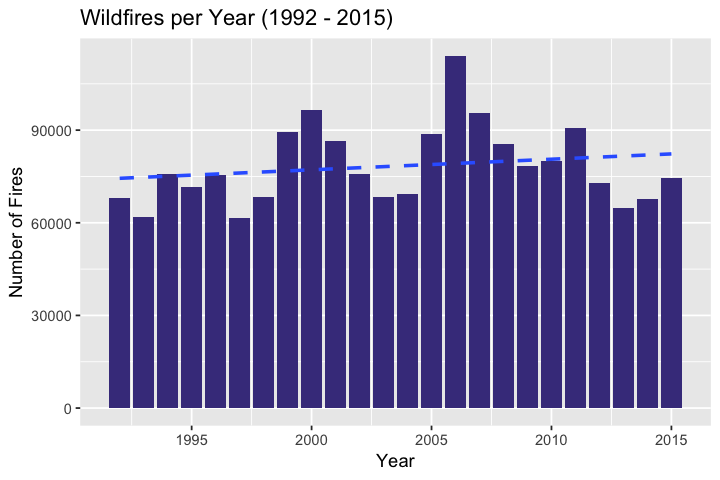

In [3]:
library(repr)
options(repr.plot.width=6, repr.plot.height=4, jupyter.plot_mimetypes = 'image/png')

fires %>% group_by(FIRE_YEAR) %>% summarize(n = n()) %>%
  ggplot(aes(x = FIRE_YEAR, y = n)) + geom_bar(stat = 'identity', fill = 'slateblue4') + 
  geom_smooth(method = 'lm', se = FALSE, linetype = 'dashed') + 
  labs(x = 'Year', y = 'Number of Fires', title = 'Wildfires per Year (1992 - 2015)')

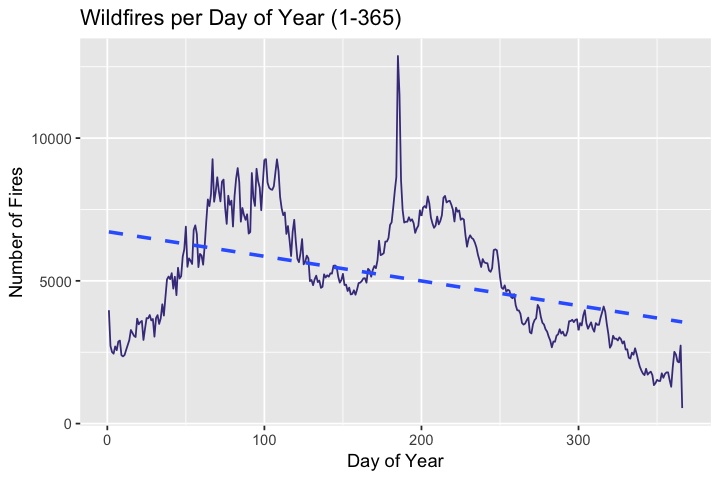

In [4]:
fires %>% group_by(DISCOVERY_DOY) %>% summarize(n = n()) %>%
  ggplot(aes(x = DISCOVERY_DOY, y = n)) + geom_line(color = 'slateblue4') + 
    geom_smooth(method = 'lm', se = FALSE, linetype = 'dashed') + 
      labs(x = 'Day of Year', y = 'Number of Fires', title = 'Wildfires per Day of Year (1-365)')

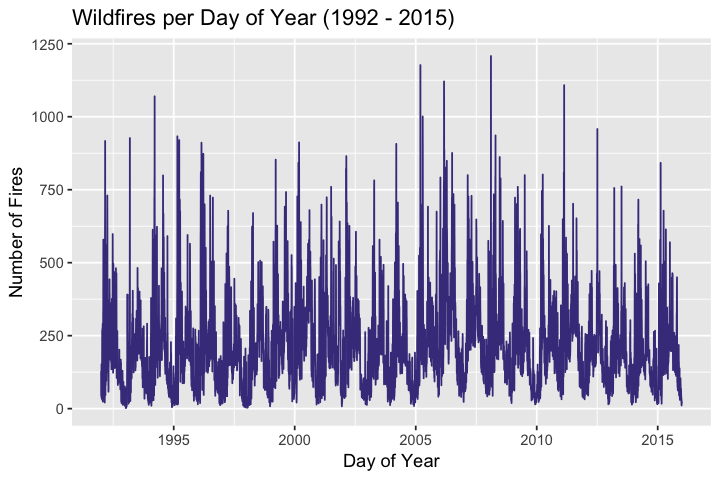

In [5]:
fires %>% mutate(date_ymd = as.Date(DISCOVERY_DATE - 2458598.5, origin = '2019-04-25')) %>%
  group_by(date_ymd) %>% summarise(n = n()) %>%  
    ggplot(aes(x = date_ymd, y = n)) + geom_line(color = 'slateblue4') + 
      labs(x = 'Day of Year', y = 'Number of Fires', title = 'Wildfires per Day of Year (1992 - 2015)')

In [6]:
test <- fires %>% group_by(STAT_CAUSE_DESCR) %>% 
  summarize(n = n()) %>%
  ggplot(aes( x = reorder(STAT_CAUSE_DESCR, n), y = n)) + geom_bar(stat='identity', fill='slateblue4') + 
  coord_flip() + labs( x= '', y = 'Number of Fires', title = 'Wilfires per Cause')

In [9]:
fire_count <- fires %>% group_by(STAT_CAUSE_DESCR) %>% 
  summarize(n = n()) %>%
  ggplot(aes( x = reorder(STAT_CAUSE_DESCR, n), y = n)) + geom_bar(stat='identity', fill='slateblue4') + 
  coord_flip() + labs( x= '', y = 'Number of Fires', title = 'Count') + 
    ggsave("./figures/fire_count.png", width = 20, height = 10, units = "cm", dpi = 320)
burn_acres <- fires %>% group_by(STAT_CAUSE_DESCR) %>%
  summarize(n = mean(FIRE_SIZE, na.rm = TRUE)) %>%
  ggplot(aes( x = reorder(STAT_CAUSE_DESCR, n), y = n)) + geom_bar(stat='identity', fill='slateblue4') + 
  coord_flip() + labs( x= '', y = 'Burn Area (Acres)', title = 'Burn Area') + 
    ggsave("./figures/burn_acres.png", width = 20, height = 10, units = "cm", dpi = 320)

burn_time <- fires %>% group_by(STAT_CAUSE_DESCR) %>% mutate(BURN_TIME = CONT_DATE - DISCOVERY_DATE) %>%
  summarize(n = mean(BURN_TIME, na.rm = TRUE)) %>%
  ggplot( aes( x = reorder(STAT_CAUSE_DESCR, n), y = n)) + geom_bar(stat='identity', fill='slateblue4') + 
  coord_flip() + labs( x= '', y = 'Burn Time (days)', title = 'Burn Time ') + 
    ggsave("./figures/burn_turn.png", width = 20, height = 10, units = "cm", dpi = 320)

<html>
<head>
<meta name="viewport" content="width=device-width, initial-scale=1">
<style>
body {font-family: Arial;}

/* Style the tab */
.tab {
  overflow: hidden;
  border: 1px solid #ccc;
  background-color: #f1f1f1;
}

/* Style the buttons inside the tab */
.tab button {
  background-color: inherit;
  float: left;
  border: none;
  outline: none;
  cursor: pointer;
  padding: 14px 16px;
  transition: 0.3s;
  font-size: 17px;
}

/* Change background color of buttons on hover */
.tab button:hover {
  background-color: #ddd;
}

/* Create an active/current tablink class */
.tab button.active {
  background-color: #ccc;
}

/* Style the tab content */
.tabcontent {
  display: none;
  padding: 6px 12px;
  border: 1px solid #ccc;
  border-top: none;
}
</style>
</head>
<body>

<h4 style="margin-bottom:5mm"> Investigation into destruction metrics for all 13 classes of fire cause. </h4>

<div class="tab">
  <button class="tablinks" onclick="openCity(event, 'Fire Count')" id="defaultOpen">Fire Count</button>
  <button class="tablinks" onclick="openCity(event, 'Burn Area')">Burn Area</button>
  <button class="tablinks" onclick="openCity(event, 'Burn Time')">Burn Time</button>
</div>

<div id="Fire Count" class="tabcontent">
   <img src="./figures/fire_count.png" alt="Fire Count per Cause" width="800" height="600"> 
    <p> <b>Fig. 3</b> Figure caption for the figure </p>
</div>

<div id="Burn Area" class="tabcontent">
  <img src="./figures/burn_acres.png" alt="Fire Count per Cause" width="800" height="600"> 
</div>

<div id="Burn Time" class="tabcontent">
  <img src="./figures/burn_turn.png" alt="Fire Count per Cause" width="800" height="600"> 
</div>

<script>
function openCity(evt, cityName) {
  var i, tabcontent, tablinks;
  tabcontent = document.getElementsByClassName("tabcontent");
  for (i = 0; i < tabcontent.length; i++) {
    tabcontent[i].style.display = "none";
  }
  tablinks = document.getElementsByClassName("tablinks");
  for (i = 0; i < tablinks.length; i++) {
    tablinks[i].className = tablinks[i].className.replace(" active", "");
  }
  document.getElementById(cityName).style.display = "block";
  evt.currentTarget.className += " active";
}

// Get the element with id="defaultOpen" and click on it
document.getElementById("defaultOpen").click();
</script>
   
</body>
</html> 


## Modeling <a class="anchor" id="modeling"></a>

First things first we are going to need to good way to visualize our results. Because we have a large multiclass classification problem, data visulization lends itself to a confusion matrix. I written a function that will plot a confusion matrix based on the examples from [Troy Walters kernel on Kaggle](https://www.kaggle.com/captcalculator/can-we-use-ml-to-predict-the-cause-of-a-wildfire).   

In [11]:
confusion_matrix <- function(predicted, validation){
  
table(validation, predicted) %>% prop.table(margin = 1) %>% as.data.frame.matrix() %>% 
    rownames_to_column(var = 'actual') %>% gather(key = 'prediction', value = 'freq',-actual) %>% replace_na(list(freq = 0)) %>%
    ggplot(aes(x = actual, y = prediction, fill = freq)) +
    geom_tile() + geom_text(aes(label = round(freq, 3)), size = 3, color = 'gray20') +
    scale_fill_gradient(low = 'orange', high = 'red', limits = c(0,1), name = 'Relative Frequency') +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    ggtitle('Confusion Matrix')

}

importance_plot <- function(fit, dataset, response){
  
  bagging_import <- tibble(
  var = dataset %>% select(-response) %>% names(), 
  import = c(fit$importance))

  ggplot(bagging_import, aes(x = reorder(var, import), y = import, fill = import)) +
    geom_bar(stat="identity", position="dodge")+ coord_flip() +
    ylab("Variable Importance")+
    xlab("") +
    guides(fill=F) +
    ggtitle("Information Value Summary")+
    scale_fill_continuous(low="lightblue", high="blue") + theme(plot.title = element_text(hjust = 0.5))
}

The original data set contains 1.88 million entires, which is too many to process on my personal machine. In order to efficently process that much data we would need to do our processing on multiple nodes of a high power computing resources, which is outside of the scope of this class. We will investiagte processing in parallel if and when possible, but for the bulk of this analysis this is outside the scope. Instead we are going to subset our data to 15% is orginal size (300,000 observations)


In [12]:
fires_no_nan <- fires %>% drop_na(STAT_CAUSE_DESCR, FIRE_YEAR, DISCOVERY_DOY, FIRE_SIZE, LATITUDE, LONGITUDE, BURN_TIME)

fires_no_nan <- fires_no_nan %>% select(STAT_CAUSE_DESCR, FIRE_YEAR, DISCOVERY_DOY, FIRE_SIZE, LATITUDE, LONGITUDE, BURN_TIME )

fires_no_nan <- fires_no_nan %>% mutate(STAT_CAUSE_DESCR = as_factor(STAT_CAUSE_DESCR))

set.seed(111)

subset_rp <- modelr::resample_partition(fires_no_nan, c(subset=0.05, nonused=0.95))

subset_fires_15 <- as_tibble(subset_rp$subset)

Splitting the data into training and testing sets.

In [13]:
set.seed(111)
rp <- modelr::resample_partition(subset_fires_15, c(train=0.7, test=0.3))
train_set15 <- as_tibble(rp$train)
test_set15 <- as_tibble(rp$test)

### A Simple tree approach <a class="anchor" id="tree"></a>

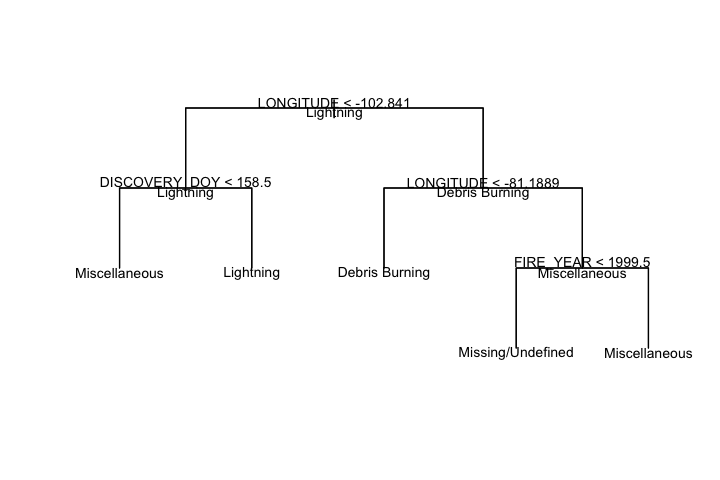

In [16]:
library(tree)
suppressMessages(library(tidymodels))
set.seed(111)

tree_fit <- tree(STAT_CAUSE_DESCR ~ ., data = train_set15)

plot(tree_fit, type = "uniform")
text(tree_fit, pretty = 1, all = TRUE, cex = 0.7)

# test_set15 %>% modelr::add_predictions(tree_fit, type = "class") %>%
#     accuracy(STAT_CAUSE_DESCR, predd

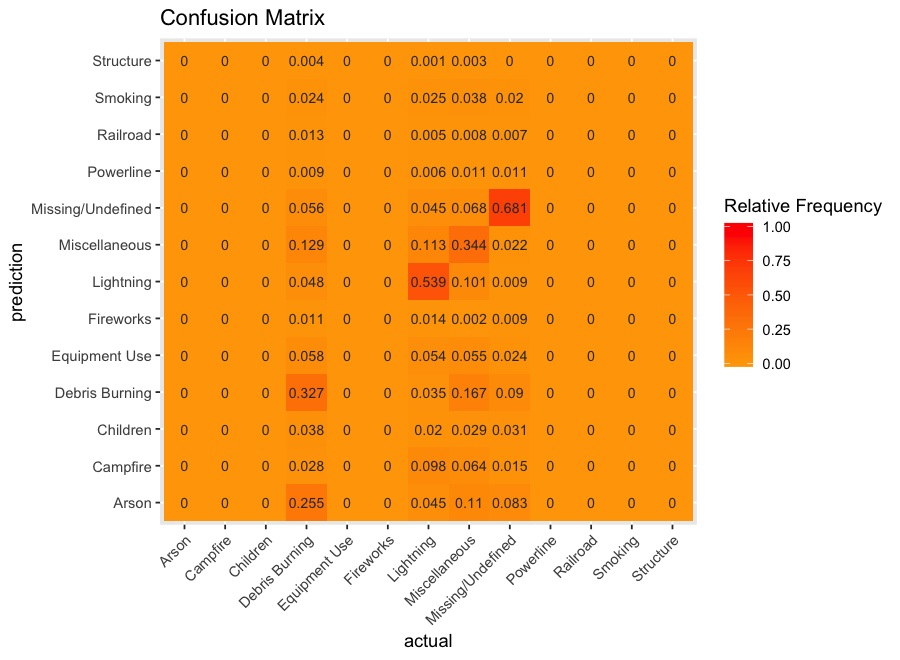

In [22]:
options(repr.plot.width=7.5, repr.plot.height=5.5, jupyter.plot_mimetypes = 'image/png')

tree_pred <- test_set15 %>% modelr::add_predictions(tree_fit, type = "class", var = 'EstCODE')
confusion_matrix(tree_pred$STAT_CAUSE_DESCR, tree_pred$EstCODE) 

### Bagging <a class="anchor" id="bagging"></a>


[1] 0.4429689

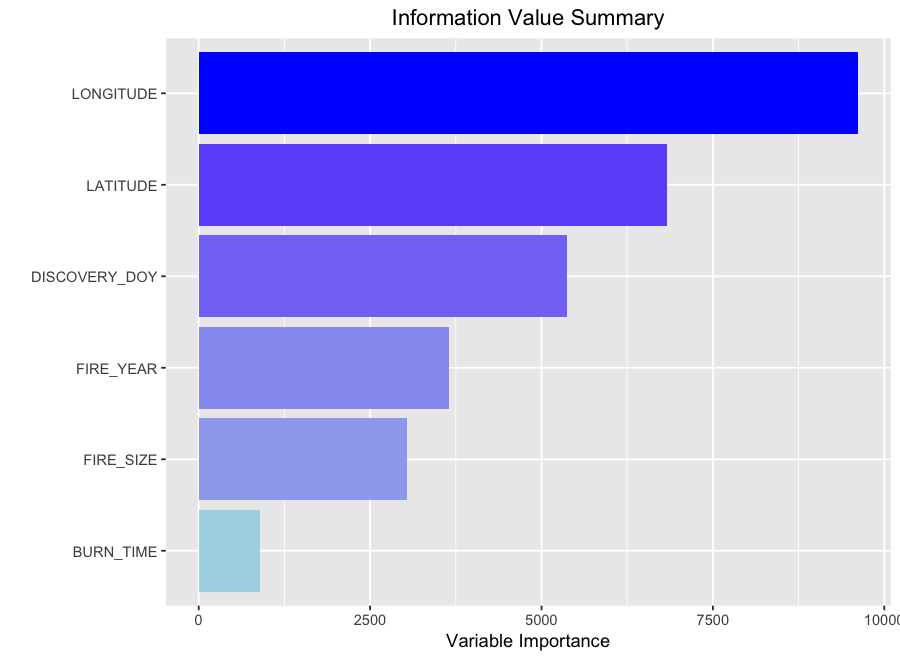

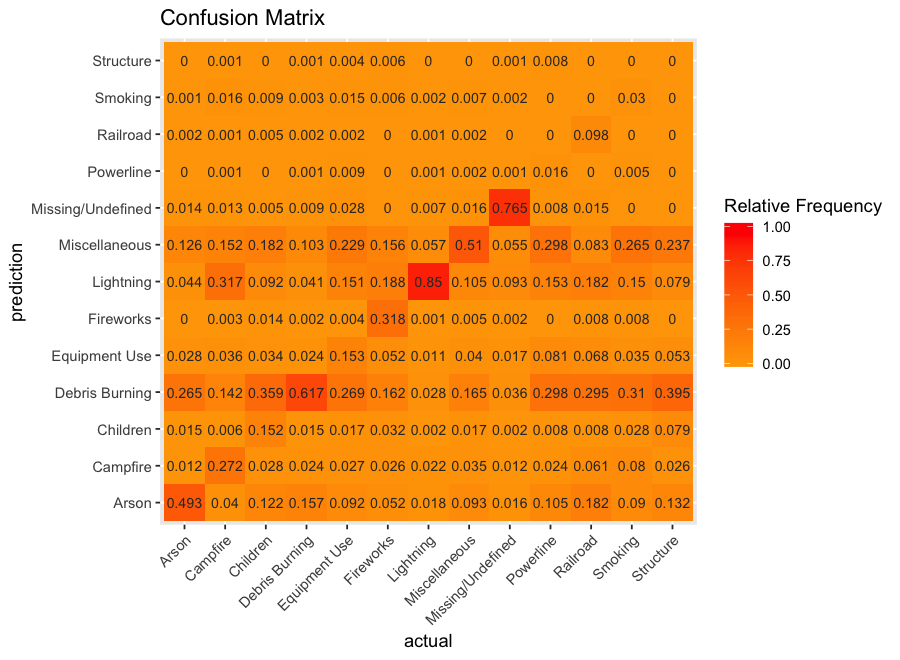

In [23]:
suppressMessages(library(randomForest))

set.seed(111)

bagging_fit <- randomForest(STAT_CAUSE_DESCR~., train_set15, mtry = 6)
bagging_pred <- test_set15 %>% mutate(EstCODE = predict(bagging_fit, test_set15, type = 'class'))

#Calculate the test error rate
mean(test_set15$STAT_CAUSE_DESCR != bagging_pred$EstCODE)

importance_plot(fit = bagging_fit, dataset = train_set15, response = 'STAT_CAUSE_DESCR')

confusion_matrix(validation = bagging_pred$STAT_CAUSE_DESCR, predicted = bagging_pred$EstCODE )

In [ ]:
rf_pred %>% count(STAT_CAUSE_DESCR, EstCODE) %>% spread(STAT_CAUSE_DESCR,n) %>% prop.table(margin = 1) %>% as.data.frame.matrix()